<a href="https://colab.research.google.com/github/ssawant/ml-jupyter-notebook/blob/master/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santoshsawant","key":"a1f1b349b891ec618054d1a8f5781bb4"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c ieee-fraud-detection

 61% 32.0M/52.5M [00:00<00:00, 50.5MB/s]
100% 52.5M/52.5M [00:00<00:00, 117MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.2MB/s]
 80% 38.0M/47.3M [00:00<00:00, 41.5MB/s]
100% 47.3M/47.3M [00:00<00:00, 96.0MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 95.5MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 77.3MB/s]


In [5]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   


**Preprocessing Data**

In [0]:
import pandas as pd
df_train_id = pd.read_csv('train_identity.csv')
df_train_tran = pd.read_csv('train_transaction.csv')

Helper function to reduce dataframe memory

In [0]:
def memory_usage_mb(df, *args, **kwargs):
  """Dataframe memory usage in MB."""
  return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
  # All types that we want to change for "ligher" ones.
  # int8 and float16 are not include because we cannot redeuce those data type
  # float32 is not include because float16 has too low precision.
  numeric2reduce = ["int16", "int32", "int64", "float64"]
  start_mem = 0
  if verbose:
    stat_mem = memory_usage_mb(df, deep=deep)
  
  for col, col_type in df.dtypes.iteritems():
    best_type = None
    if col_type in numeric2reduce:
      downcast = "integer" if "int" in str(col_type) else "float"
      df[col] = pd.to_numeric(df[col], downcast=downcast)
      best_type = df[col].dtype.name
    
    # Log the conversion performed.
    if verbose and best_type is not None and best_type != str(col_type):
      print(f"Column '{col}' converted from {col_type} to {best_type}")
    
  if verbose:
    end_mem = memory_usage_mb(df, deep=deep)
    diff_mem = start_mem - end_mem
    percent_mem = 100 * diff_mem / start_mem
    print(f"Memory usage decreased from"
          f" {start_mem:.2f}MB to {end_mem:.2f}MB"
          f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
  return df


In [79]:
df_train_id.head()
df_train_id.shape
# memory_usage_mb(df_train_id)

(144233, 41)

In [80]:
df_train_tran.head()
# memory_usage_mb(df_train_tran)

1775.152359008789

In [82]:
df_train_tran.shape

(590540, 394)

In [83]:
df_train_id.shape

(144233, 41)

In [0]:
df_train = pd.merge(df_train_tran, df_train_id, on='TransactionID', how='left')

In [85]:
print(f'Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.


In [0]:
del df_train_tran, df_train_id

In [90]:
df_train.head()
memory_usage_mb(df_train)

1959.8762512207031

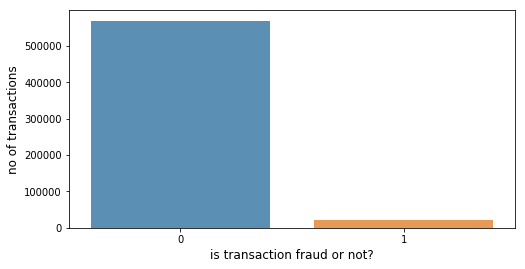

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
count = df_train['isFraud'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('no of transactions', fontsize=12)
plt.xlabel('is transaction fraud or not?', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Proportion of Missing Values in Input Features')

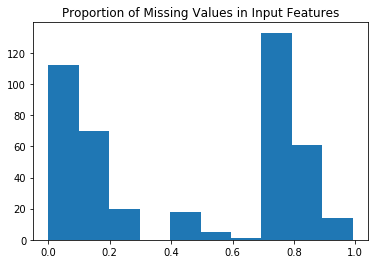

In [92]:
no_data_sample = len(df_train.index)

input_features_missing_proportions = df_train.isnull().sum() / no_data_sample

plt.hist(input_features_missing_proportions)
plt.title('Proportion of Missing Values in Input Features')

Removing columns which has more then 60% nan values

In [0]:
df_train = df_train.loc[:, df_train.isnull().mean() <=.6]

In [95]:
df_train.shape

(590540, 226)

In [96]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,NaN,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


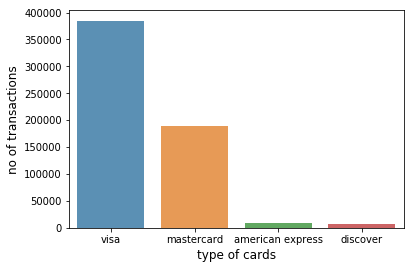

In [97]:
count = df_train['card4'].value_counts()

sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('no of transactions', fontsize=12)
plt.xlabel('type of cards', fontsize=12)
plt.show()

In [98]:
df_train.select_dtypes(exclude=['int', 'float']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [99]:
numeric_col = df_train._get_numeric_data().columns
numeric_col

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=213)

In [100]:
memory_usage_mb(df_train)

1022.7400207519531

In [0]:
# replacing null missing value with mean of dataset
numeric_column = [i for i in numeric_col]
for i in numeric_column:
  df_train[i]=df_train[i].fillna(df_train[i].median())

In [102]:
data_num = df_train[numeric_column]
data_num.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,43.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,43.0,111.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,15.0,43.0,52.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
num_cat = df_train.select_dtypes(exclude=['int', 'float']).columns
num_cat = [i for i in num_cat]
num_cat

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [104]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
imp.fit(df_train[num_cat])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [0]:
df_train[num_cat] = imp.transform(df_train[num_cat])
data_cat = df_train[num_cat]

In [106]:
data_cat.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,gmail.com,T,T,T,M2,F,T,F,F,T
1,W,mastercard,credit,gmail.com,T,T,T,M0,T,T,F,F,T
2,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,T,T,T,M0,T,F,F,F,T
4,H,mastercard,credit,gmail.com,T,T,T,M0,F,F,F,F,T


In [107]:
# finding no of category in categorical columns
data_cat = data_cat.astype('category')
cat_level = data_cat.apply(lambda col: len(col.cat.categories))
cat_level

ProductCD         5
card4             4
card6             4
P_emaildomain    59
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
dtype: int64

In [108]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,13.0,13.0,0.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,43.0,0.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,315.0,315.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,43.0,111.0,T,T,T,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,8.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,15.0,43.0,52.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
data_cat = pd.get_dummies(data_cat[num_cat])

In [0]:
df = pd.concat([data_num, data_cat], axis=1)

In [111]:
del df_train
del data_num
del data_cat
del cat_level
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G         12G        168M        840K        463M        4.7G
Swap:            0B          0B          0B


Traning and test data

In [112]:
df = reduce_memory_usage(df, deep=True, verbose=True)

Column 'TransactionID' converted from int64 to int32
Column 'isFraud' converted from int64 to int8
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3' converted from float64 to float32
Column 'C4' converted from float64 to float32
Column 'C5' converted from float64 to float32
Column 'C6' converted from float64 to float32
Column 'C7' converted from float64 to float32
Column 'C8' converted from float64 to float32
Column 'C9' converted from float64 to float32
Column 'C10' converted from float64 t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,3:], df['isFraud'], test_size=0.20, random_state=42)

              total        used        free      shared  buff/cache   available
Mem:            12G         11G        188M        840K        1.4G        9.4G
Swap:            0B          0B          0B
